In [46]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from lingua import LanguageDetectorBuilder
import matplotlib.pyplot as plt
import geopandas as gpd
import math
import matplotlib.patches as mpatches



In [3]:
listings_url = './data/listings-09-2022.csv'
listings_raw=pd.read_csv(listings_url)

## Convert price to numeric format

In [4]:
listings_raw["price"] = pd.to_numeric(listings_raw["price"].str.replace(r'[$,]', "", regex = True))

## Write neighbourhood_cleansed value into neighbourhood column

In [5]:
listings_raw["neighbourhood"] = listings_raw["neighbourhood_cleansed"]
listings_raw["neighbourhood_group"] = listings_raw["neighbourhood_group_cleansed"]

## Drop listings without reviews

In [6]:
count_of_listings_with_reviews = len(listings_raw[listings_raw["number_of_reviews"] > 0])
count_of_listings_without_reviews = len(listings_raw[listings_raw["number_of_reviews"] == 0])
print("Listings with reviews: ", count_of_listings_with_reviews)
print("Listings without reviews: ", count_of_listings_without_reviews)

Listings with reviews:  13812
Listings without reviews:  2868


In [7]:
listings_with_reviews = listings_raw[listings_raw["number_of_reviews"] > 0]

## Add separate fields for smoke and carbon monoxide detectors

In [8]:
carbon_monoxide_substring = 'Carbon monoxide alarm'
smoke_alarm_substring = 'Smoke alarm'
listings_with_reviews.loc[:, 'has_smoke_alarm'] = listings_with_reviews["amenities"].str.contains(smoke_alarm_substring)
listings_with_reviews.loc[:, 'has_co_alarm'] = listings_with_reviews["amenities"].str.contains(carbon_monoxide_substring)

/tmp/ipykernel_32918/340655119.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_with_reviews.loc[:, 'has_smoke_alarm'] = listings_with_reviews["amenities"].str.contains(smoke_alarm_substring)
/tmp/ipykernel_32918/340655119.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_with_reviews.loc[:, 'has_co_alarm'] = listings_with_reviews["amenities"].str.contains(carbon_monoxide_substring)


## Drop listings without beds

In [9]:
count_of_listings_without_beds = len(listings_with_reviews[listings_with_reviews["beds"].isnull()])
count_of_listings_with_beds = len(listings_with_reviews[listings_with_reviews["beds"].notnull()])
print("Listings without information about beds: ", count_of_listings_without_beds)
print("Listings with information about beds: ", count_of_listings_with_beds)

Listings without information about beds:  234
Listings with information about beds:  13578


In [10]:
listings_with_beds = listings_with_reviews[listings_with_reviews["beds"].notnull()]

## Drop listings without bedrooms

In [11]:
count_of_listings_without_bedrooms = len(listings_with_reviews[listings_with_reviews["bedrooms"].isnull()])
count_of_listings_with_bedrooms = len(listings_with_reviews[listings_with_reviews["bedrooms"].notnull()])
print("Listings without information about bedrooms: ", count_of_listings_without_bedrooms)
print("Listings with information about bedrooms: ", count_of_listings_with_bedrooms)

Listings without information about bedrooms:  1109
Listings with information about bedrooms:  12703


In [12]:
listings_with_bedrooms = listings_with_reviews[listings_with_reviews["bedrooms"].notnull()]

In [13]:
def get_fitted_X(X, polynomial_degree: int):
    poly_reg=PolynomialFeatures(degree=polynomial_degree)
    X_poly=poly_reg.fit_transform(X)
    return X_poly

def get_linear_regression_model(X, y, polynomial_degree: int):
    X_poly_fitted=get_fitted_X(X, polynomial_degree)
    lin_reg_model=LinearRegression()
    lin_reg_model.fit(X_poly_fitted,y)
    return lin_reg_model

def get_mse(X_train, y_train, X_test, y_test, polynomial_degree: int):
    lin_reg_model = get_linear_regression_model(X_train, y_train, polynomial_degree)
    X_test_poly_fitted=get_fitted_X(X_test, polynomial_degree)
    y_predicted = lin_reg_model.predict(X_test_poly_fitted)
    return mean_squared_error(y_test, y_predicted)

def get_r2_score(X_train, y_train, X_test, y_test, polynomial_degree: int):
    lin_reg_model = get_linear_regression_model(X_train, y_train, polynomial_degree)
    X_test_poly_fitted=get_fitted_X(X_test, polynomial_degree)
    y_predicted = lin_reg_model.predict(X_test_poly_fitted)
    return r2_score(y_test, y_predicted)

def print_mse_and_r2_plots(range: range, mse_list: list, r2_list: list, title = ''):
    fig, ax = plt.subplots(2, sharex=True)
    if title != '':
        fig.suptitle(title)
    ax[0].plot(range, mse_list, color='blue')
    ax[0].set_xlabel('Polynomial regression degree')
    ax[0].set_ylabel('mean squared error')
    ax[0].set_yscale('log')
    ax[1].plot(range, r2_list, color='red')
    ax[1].set_xlabel('Polynomial regression degree')
    ax[1].set_ylabel('R² score')
    ax[1].set_yscale('log')

In [14]:
relevant_columns = [
  "neighbourhood", 
  "property_type", 
  "room_type", 
  "accommodates", 
  "has_smoke_alarm", 
  "has_co_alarm",
  "beds"
]

X_beds=listings_with_beds[relevant_columns].values
y_beds=listings_with_beds["price"].values

In [15]:
X_beds_train,X_beds_test,y_beds_train,y_beds_test=train_test_split(X_beds,y_beds,test_size=0.2,random_state=0)

In [16]:
mse_list = []
r2_list = []

degree_range = range(1, 11)

X = X_beds
y = y_beds

for polynomial_degree in degree_range:
    mse = get_mse(X_train=X, X_test=X, y_train=y, y_test=y, polynomial_degree=polynomial_degree)
    mse_list.append(mse)
    r2 = get_r2_score(X_train=X, X_test=X, y_train=y, y_test=y, polynomial_degree=polynomial_degree)
    r2_list.append(r2)

print_mse_and_r2_plots(range=degree_range, mse_list=mse_list, r2_list=r2_list)

ValueError: could not convert string to float: 'Zehlendorf  Südwest'

# Playing around with NLP and the reviews

In [67]:
reviews_url = './data/reviews-09-2022.csv'
reviews_raw = pd.read_csv(reviews_url)

In [68]:
reviews_filtered = reviews_raw[reviews_raw["comments"].notna()]

In [ ]:
# detector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().build()

# reviews_language = reviews_filtered.copy()
# for i, row in reviews_language.iterrows():
#     if i % 100 == 0:
#       print("Now processing iteration ", i)
#     confidence_values = detector.compute_language_confidence_values(row["comments"])
#     language_lowercase = str(confidence_values[0].language).split(".")[1].lower()
#     reviews_language.at[i,'language_detected'] = language_lowercase
#     reviews_language.at[i,'language_confidence'] = confidence_values[0].value

# reviews_language_url = './data/reviews-09-2022-language.csv'
# reviews_language.to_csv(reviews_language_url, index=False, sep=";", lineterminator="\r")

'\ndetector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().build()\n\nreviews_language = reviews_filtered.copy()\nfor i, row in reviews_language.iterrows():\n    if i % 100 == 0:\n      print("Now processing iteration ", i)\n    confidence_values = detector.compute_language_confidence_values(row["comments"])\n    language_lowercase = str(confidence_values[0].language).split(".")[1].lower()\n    reviews_language.at[i,\'language_detected\'] = language_lowercase\n    reviews_language.at[i,\'language_confidence\'] = confidence_values[0].value\n\nreviews_language_url = \'./data/reviews-09-2022-language.csv\'\nreviews_language.to_csv(reviews_language_url, index=False, sep=";", lineterminator="\r")\n'

The custom line terminator `\r` is necessary because some of the comments have linebreaks (`\n`) which break the interpretation of the csv file.

In [47]:
reviews_language_url = './data/reviews-09-2022-language.csv'
reviews_language_read = pd.read_csv(reviews_language_url, sep=";", lineterminator="\r")

In [48]:
min_required_confidence = 0.6
reviews_confident_language = reviews_language_read[reviews_language_read["language_confidence"] > min_required_confidence]
review_language_occurencies = reviews_confident_language.groupby(by="language_detected").size()
top_10_review_languages = review_language_occurencies.sort_values(ascending=False).head(10)
top_10_review_languages

language_detected
english    251904
german     116793
french      17428
spanish     11216
dutch        4991
italian      4316
russian      2862
chinese      1643
korean       1577
danish       1474
dtype: int64

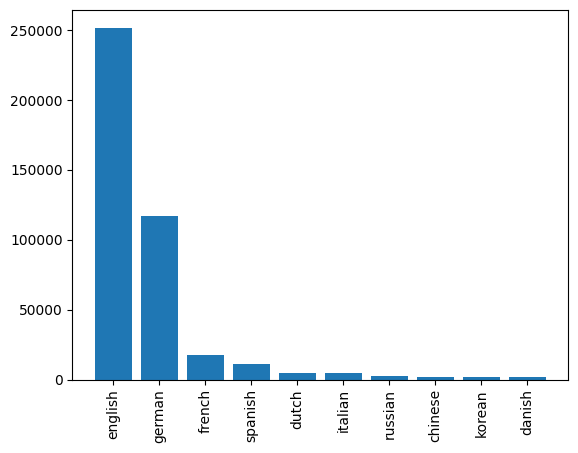

In [21]:
labels = top_10_review_languages.keys()
sizes = top_10_review_languages.values

fig, ax = plt.subplots()
ax.bar(labels, sizes)
plt.xticks(rotation=90)
plt.show()

In [22]:
berlin_neighbourhoods_url = "./data/neighbourhoods-09-2022.geojson"
berlin_neighbourhoods_raw = gpd.read_file(berlin_neighbourhoods_url)
berlin_neighbourhoods_raw[berlin_neighbourhoods_raw["neighbourhood"].isnull()]

,neighbourhood,neighbourhood_group,geometry
11,None,None,"MULTIPOLYGON (((13.61659 52.58154, 13.61458 52..."
12,None,None,"MULTIPOLYGON (((13.61668 52.57868, 13.60703 52..."


<AxesSubplot: >

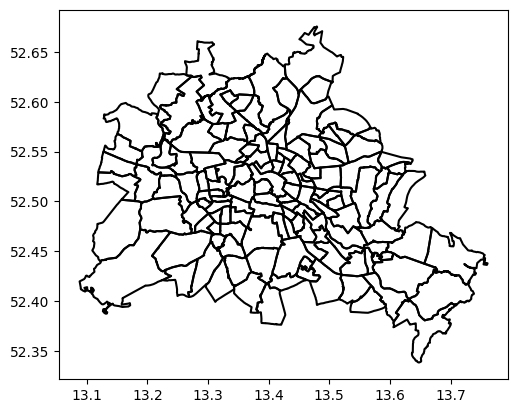

In [23]:
berlin_neighbourhoods = berlin_neighbourhoods_raw[berlin_neighbourhoods_raw["neighbourhood"].notnull()]
berlin_neighbourhoods.boundary.plot(color="black")

In [124]:
def get_neighbourhoods_and_review_counts_for_language(language):
  listings_and_neighbourhoods = berlin_neighbourhoods.merge(listings_with_reviews, on="neighbourhood", how="right")
  listings_and_neighbourhoods = listings_and_neighbourhoods.rename(columns={"id": "listing_id"})

  language_reviews = reviews_confident_language[reviews_confident_language["language_detected"] == language]
  language_listings_and_neighbourhoods = language_reviews.merge(listings_and_neighbourhoods, on="listing_id")
  language_review_counts = language_listings_and_neighbourhoods.groupby(by="neighbourhood").size().reset_index(name='counts')
  
  return berlin_neighbourhoods.merge(language_review_counts, how="left").fillna(0)

def plot_review_counts_per_neighbourhood_for_multiple_language(languages: list[str]):
  rows_count = math.ceil(len(languages) / 2)
  fig, axs = plt.subplots(nrows=rows_count, ncols=2, figsize=(15, 15))

  ravelled_axes = axs.ravel()

  if len(ravelled_axes) > len(languages):
    fig.delaxes(ravelled_axes[-1])

  for (index, language), ax in zip(enumerate(languages), ravelled_axes):
    language_data = get_neighbourhoods_and_review_counts_for_language(language)
    total_occurencies = review_language_occurencies[language]
    language_data["share"] = language_data["counts"] / total_occurencies

    ax.plot = language_data.plot(column = "share", ax = ax, legend=True, legend_kwds={'label': "Share of all reviews in " + language})
    ax.set_title(language)

    legend_patch = mpatches.Patch(color='white', label='n = ' + f'{total_occurencies:,}')
    ax.legend(handles=[legend_patch], frameon = False)
  
  fig.suptitle("Share of reviews in the respective language per neighbourhood", fontsize=16)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()


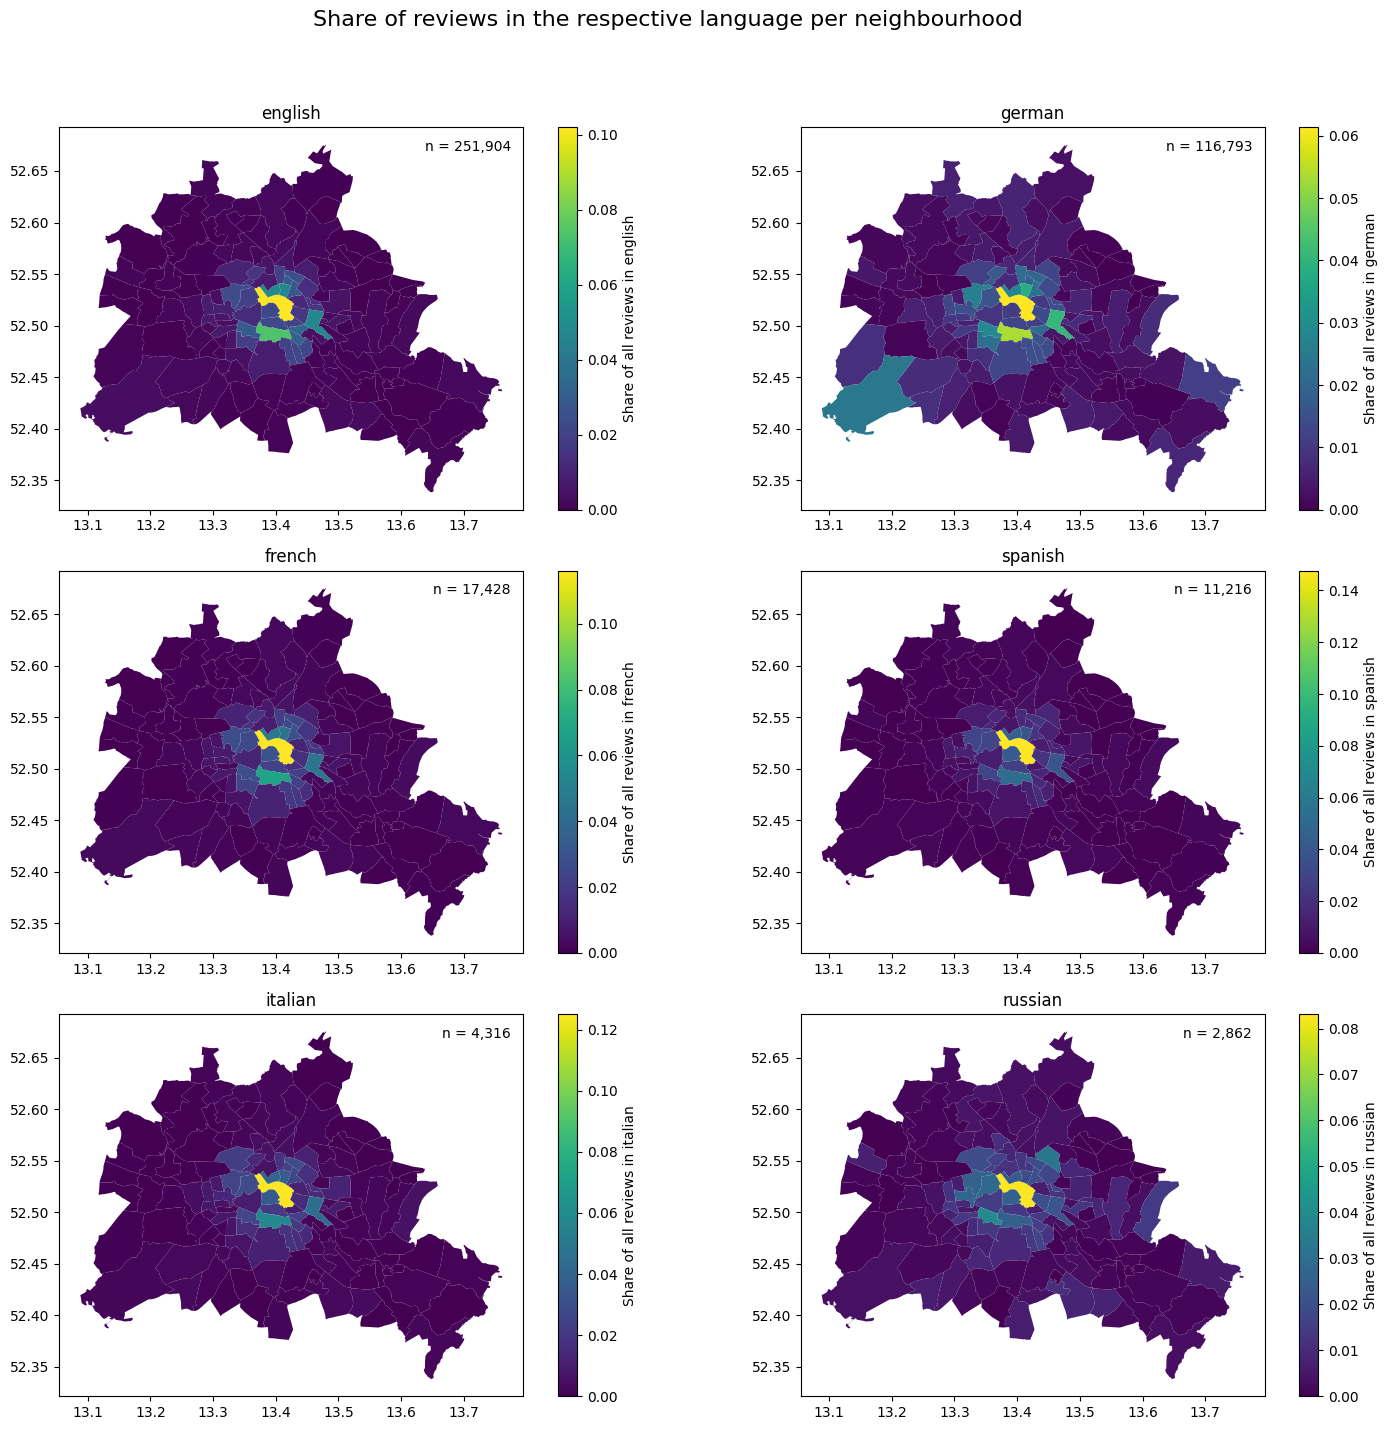

In [125]:
languages = ["english", "german", "french", "spanish", "italian", "russian"]
plot_review_counts_per_neighbourhood_for_multiple_language(languages)

In [ ]:
detector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().build()

In [27]:
listings_with_name = listings_with_reviews.head(100)[listings_with_reviews["name"].notna()].copy()
for i, row in listings_with_name.iterrows():
  confidence_values = detector.compute_language_confidence_values(row["name"])

  description_language_lowercase = str(confidence_values[0].language).split(".")[1].lower()
  listings_with_name.at[i,'name_language'] = description_language_lowercase
  listings_with_name.at[i,'name_language_confidence'] = confidence_values[0].value

listings_with_name["name_language_confidence"].describe()

/tmp/ipykernel_32918/4018513914.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listings_with_name = listings_with_reviews.head(100)[listings_with_reviews["name"].notna()].copy()


count    100.000000
mean       0.366477
std        0.196001
min        0.068038
25%        0.218787
50%        0.328708
75%        0.482415
max        0.888881
Name: name_language_confidence, dtype: float64

In [28]:
listings_with_name_and_description = listings_with_reviews[listings_with_reviews["name"].notna() & listings_with_reviews["description"].notna()]
listings_with_name_and_description.reset_index(inplace=True)

In [32]:
# listings_languages = listings_with_name_and_description.copy()

# for i, row in listings_languages.iterrows():
#   if i % 100 == 0:
#     print("Now processing iteration ", i)
#   confidence_values_description = detector.compute_language_confidence_values(row["description"])

#   description_language_lowercase = str(confidence_values_description[0].language).split(".")[1].lower()
#   listings_languages.at[i,'description_language'] = description_language_lowercase
#   listings_languages.at[i,'description_language_confidence'] = confidence_values_description[0].value

# listings_language_url = './data/listings-09-2022-language.csv'

# listings_languages.drop(columns=["index"]).to_csv(listings_language_url, index=False, sep=";", lineterminator="\r")

In [33]:
listings_language_url = './data/listings-09-2022-language.csv'
listings_language_read = pd.read_csv(listings_language_url, sep=";", lineterminator="\r")

In [34]:
listings_language_read["description_language_confidence"].describe()

count    13612.000000
mean         0.988646
std          0.082567
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: description_language_confidence, dtype: float64

In [35]:
min_required_confidence = 0.6
listings_desc_confident_language = listings_language_read[listings_language_read["description_language_confidence"] > min_required_confidence]
listing_desc_language_occurencies = listings_desc_confident_language.groupby(by="description_language").size()
top_10_listing_languages = listing_desc_language_occurencies.sort_values(ascending=False).head(10)
top_10_listing_languages

description_language
english       8637
german        4676
russian         52
spanish         22
french          21
italian         12
dutch            5
polish           5
turkish          4
portuguese       4
dtype: int64

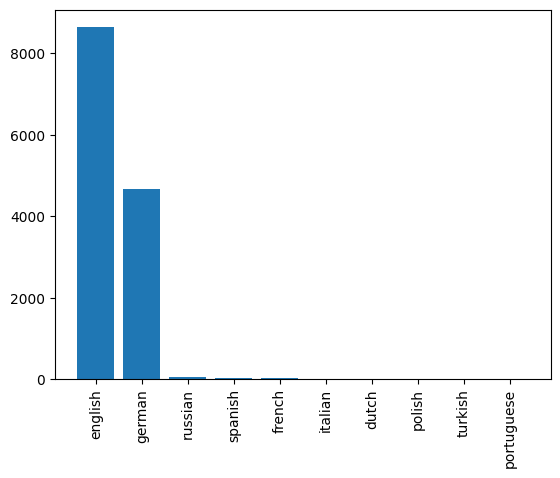

In [36]:
labels = top_10_listing_languages.keys()
sizes = top_10_listing_languages.values

fig, ax = plt.subplots()
ax.bar(labels, sizes)
plt.xticks(rotation=90)
plt.show()

In [134]:
# import matplotlib.colors as colors
#  vmin, vmax, vcenter = 0, language_data.counts.max(), language_data.counts.max() / 2
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vmax=vmax, vcenter=vcenter)
# cbar = plt.cm.ScalarMappable(norm=divnorm)
# # Divide existing axes and create
# # new axes at right side of image
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.15)
# fig.colorbar(cbar, cax=cax, label="Number of reviews")

def get_neighbourhoods_and_description_counts_for_language(language):
  language_listings = listings_desc_confident_language[listings_desc_confident_language["description_language"] == language]
  language_counts = language_listings.groupby(by="neighbourhood").size().reset_index(name='counts')
  
  return berlin_neighbourhoods.merge(language_counts, how="left").fillna(0)

def plot_description_shares_per_neighbourhood_for_multiple_languages(languages: list[str]):
  rows_count = math.ceil(len(languages) / 2)
  fig, axs = plt.subplots(nrows=rows_count, ncols=2, figsize=(15, 15))

  ravelled_axes = axs.ravel()

  if len(ravelled_axes) > len(languages):
    fig.delaxes(ravelled_axes[-1])

  for (index, language), ax in zip(enumerate(languages), ravelled_axes):
    language_data = get_neighbourhoods_and_description_counts_for_language(language)
    total_occurencies = listing_desc_language_occurencies[language]
    language_data["share"] = language_data["counts"] / total_occurencies
    
    ax.plot = language_data.plot(column = "share", ax = ax, legend=True, legend_kwds={'label': "Share of all descriptions in " + language})
    ax.set_title(language)

    legend_patch = mpatches.Patch(color='white', label='n = ' + f'{total_occurencies:,}')
    ax.legend(handles=[legend_patch], frameon = False)
  
  fig.suptitle("Share of descriptions in the respective language per neighbourhood", fontsize=22)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

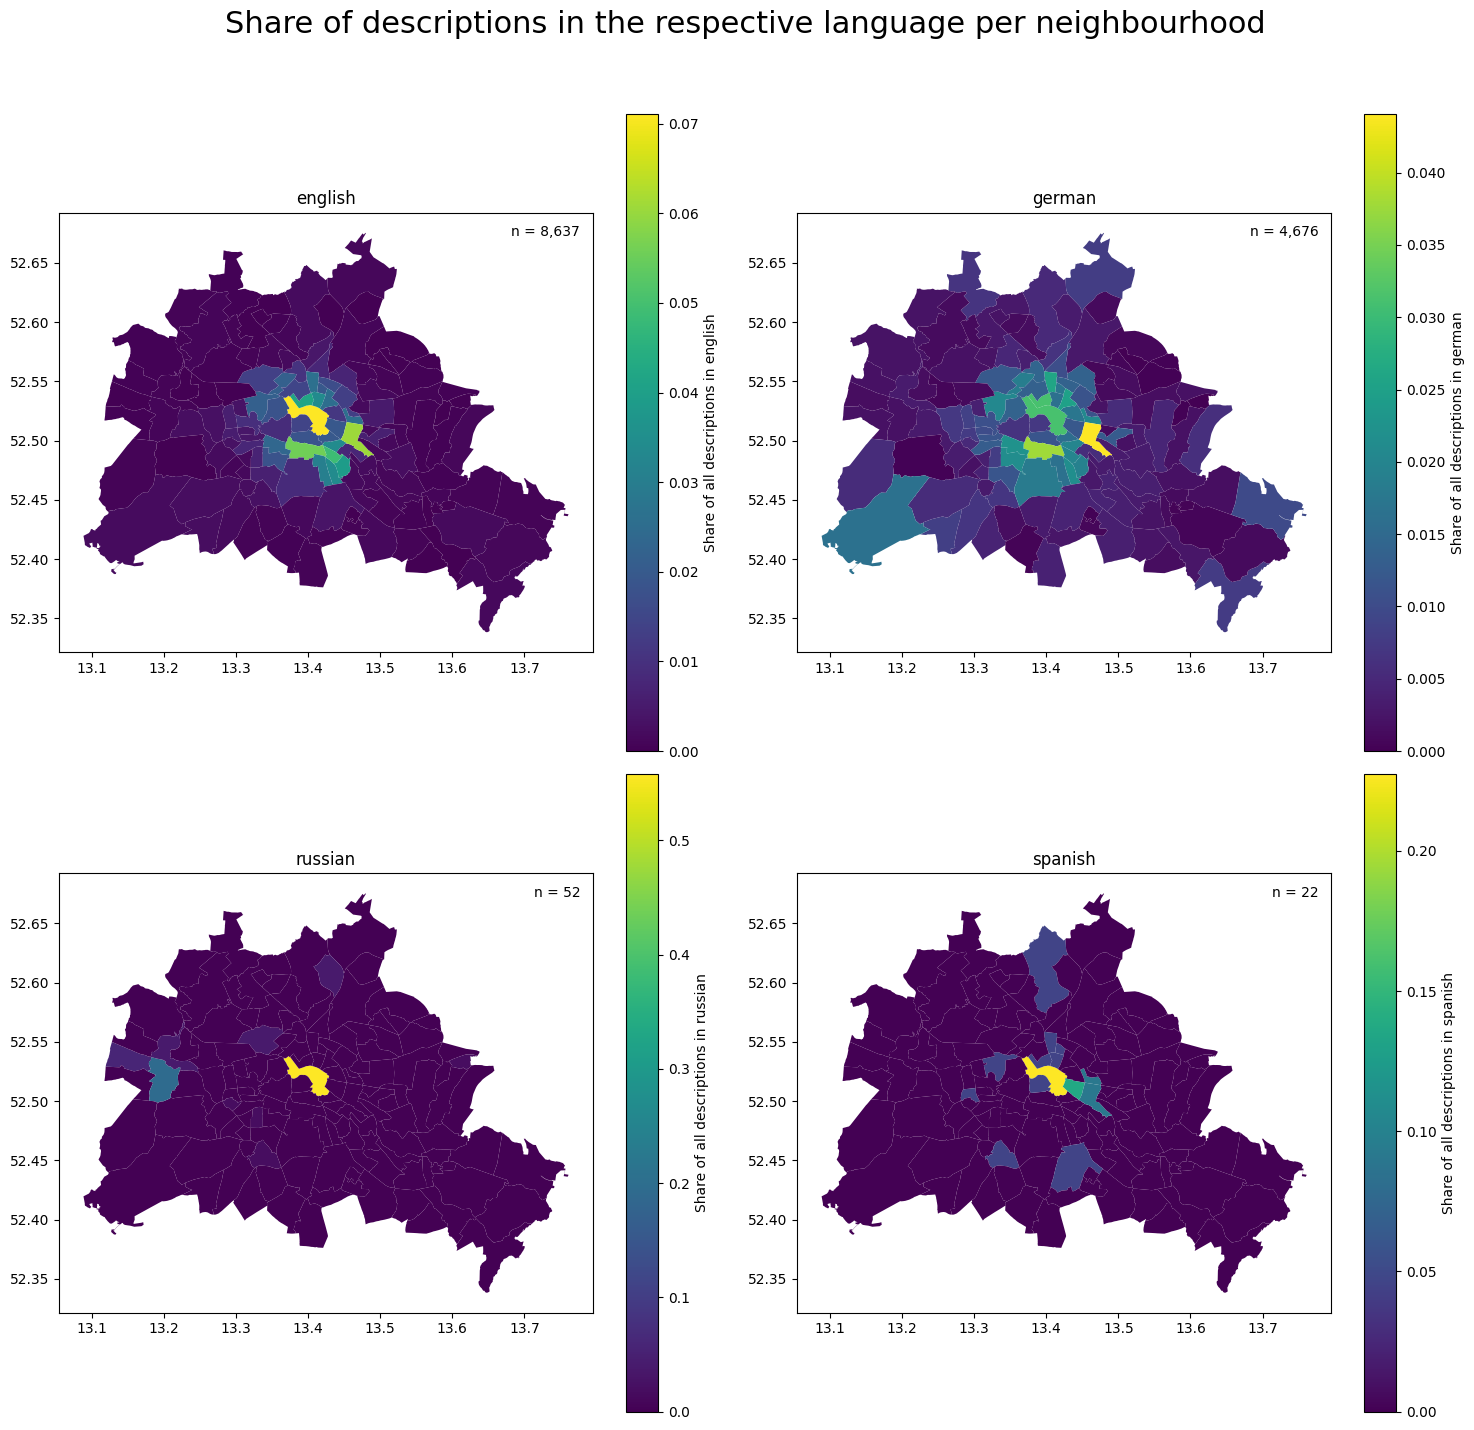

In [136]:
plot_description_shares_per_neighbourhood_for_multiple_languages(["english", "german", "russian", "spanish" ])

In [151]:
get_neighbourhoods_and_description_counts_for_language("russian").sort_values(by="counts", ascending=False).head(5)[["neighbourhood", "counts"]]

,neighbourhood,counts
15,Alexanderplatz,29.0
50,Wilhelmstadt,10.0
45,Brunsbütteler Damm,3.0
19,Parkviertel,2.0
113,Spandau Mitte,2.0


In [150]:
russian_listings = listings_desc_confident_language[listings_desc_confident_language["description_language"] == "russian"]
russian_listings_in_wilhelmstadt = russian_listings[russian_listings["neighbourhood"] == "Wilhelmstadt"]
russian_listings_in_wilhelmstadt.sort_values("host_id")[["host_id", "price", "accommodates", "name"]]

,host_id,price,accommodates,name,description
2818,52747435,60.0,4,Двухкомнатная квартира на Штаакенер (19),Если вы хотите пожить в знаменитом районе г.Б...
6147,52747435,56.0,4,Двухкомнатная квартира на Штаакенер (32),Если вы хотите пожить в знаменитом районе г.Бе...
6359,52747435,60.0,5,Cosy 2rooms Apartment in Spandau area (2),"Уютная двухкомнатная квартира, оснащенная всем..."
6838,52747435,60.0,4,Двухкомнатная квартира на Штаакенер (5),Если вы хотите пожить в знаменитом районе г. Б...
7199,52747435,57.0,4,Двухкомнатная квартира на Штаакенер (24.2),Если вы хотите пожить в знаменитом районе г.Бе...
4623,79430806,55.0,5,Stylish 2-rooms flat on Staakenerstr. Spandau(21),Современная просторная двухкомнатная квартира ...
5860,79430806,55.0,5,Comfy 2rooms flat in Spandau (29),Современная просторная двухкомнатная квартира ...
6474,79430806,51.0,4,2Rooms flat in quiet neighborhood/Spandau (22),Уютная небольшая двухкомнатная квартира 44 м2 ...
7162,79430806,53.0,4,Small 2Rooms flat (24.1)/Spandau,Маленькая 2-х комнатная квартира площадью 37 м...
7419,79430806,55.0,5,Nice 2Rooms flat/Spandau (17),Современная просторная двухкомнатная квартира ...


## Sentiment analysis

In [49]:
english_reviews = reviews_confident_language[reviews_confident_language["language_detected"] == "english"]

In [175]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from flair.models import TextClassifier
from flair.data import Sentence
from segtok.segmenter import split_single

In [38]:
classifier = TextClassifier.load('en-sentiment')

2023-01-10 01:41:33,404 loading file /home/lebkuchen/.flair/models/sentiment-en-mix-distillbert_4.pt


In [81]:
def get_sentences_from_text(text: str):
    sentences = [sent for sent in split_single(text)]
    return sentences

def predict(sentence: str):
    if sentence == "":
        return 0
    text = Sentence(sentence)
    classifier.predict(text)
    value = text.labels[0].to_dict()['value'] 
    if value == 'POSITIVE':
        result = text.to_dict()['all labels'][0]['confidence']
    else:
        result = -(text.to_dict()['all labels'][0]['confidence'])
    return round(result, 3)

def get_scores(sentences):
    results = []
    
    for i in range(0, len(sentences)): 
        results.append(predict(sentences[i]))
    return results

def get_sum(scores):
    result = round(sum(scores), 3)
    return result

In [94]:
english_reviews_sample = english_reviews.sample(n = 50000)

In [96]:
reviews_with_sentiment = english_reviews_sample.copy()
reviews_with_sentiment.reset_index(inplace=True)

for index, review in reviews_with_sentiment.iterrows():
  if index % 100 == 0:
    print("Now processing iteration ", index)
  
  review_comment = review["comments"]
  comment_lowercase = review_comment.lower()
  comment_without_html_linebreaks = comment_lowercase.replace("<br/>", "")

  sentences = get_sentences_from_text(comment_without_html_linebreaks)
  scores = get_scores(sentences)
  sentiment_sum = get_sum(scores)
  
  reviews_with_sentiment.at[index, 'sentiment'] = sentiment_sum

reviews_sentiment_url = './data/reviews-09-2022-sentiment.csv'
english_reviews_sample.drop(columns=["index"]).to_csv(reviews_sentiment_url, index=False, sep=";", lineterminator="\r")

Now processing iteration  0


In [ ]:
reviews_sentiment_url = './data/reviews-09-2022-sentiment.csv'
reviews_sentiment_read = pd.read_csv(reviews_sentiment_url, sep=";", lineterminator="\r")

In [80]:
text = """It's very good apartment that situated near Nordbahnhof s-bahn and u-bahn station. Two big rooms and four sleeping places are ideal for 3 or 4 people. Good flat for a good price! It's just 5 min by foot to Oranienburger str., 10 min to Unter-den-Linden or less. Javier and Rubin are very friendly. Thank you for unbelievable stay in Berlin!"""
sentences = get_sentences_from_text(text)
results = get_scores_and_weights(sentences)
print(results)
score = get_weighted_score(results)

[(0.996, 12), (0.994, 14), (1.0, 6), (-0.876, 15), (0.999, 6), (0.996, 7)]
